In [1]:
import matplotlib.pyplot as plt
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

import ast
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, average_precision_score, \
    multilabel_confusion_matrix
from scipy.stats import ttest_ind
%matplotlib inline

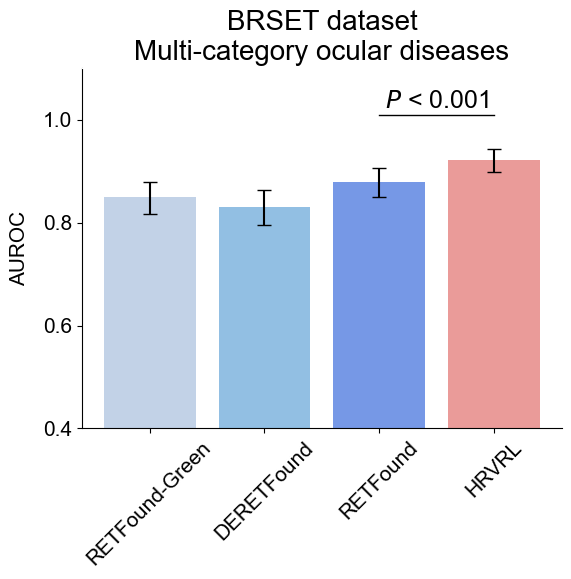

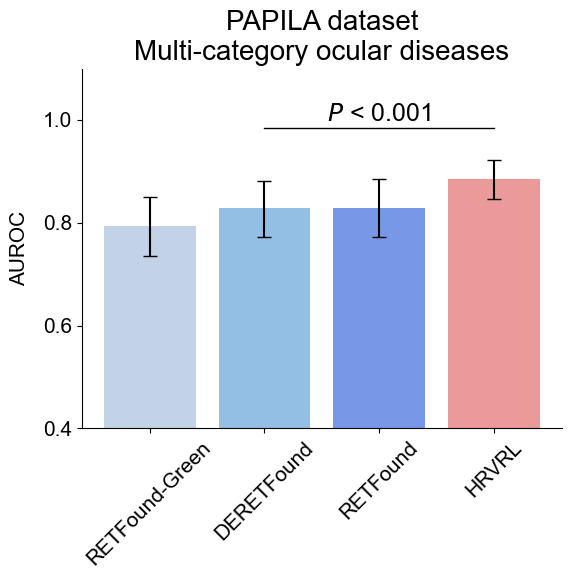

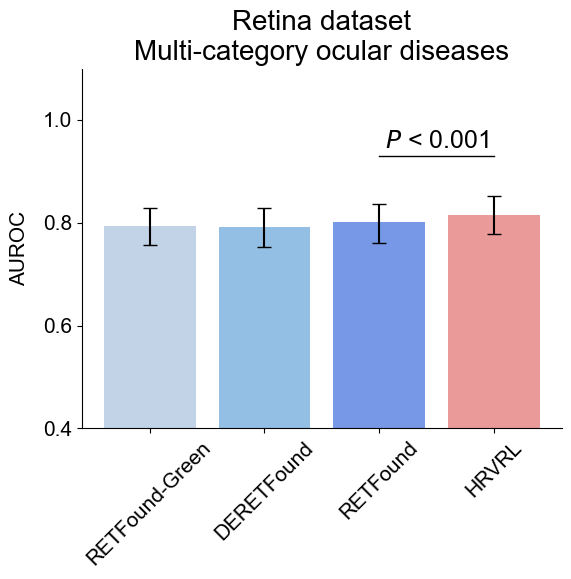

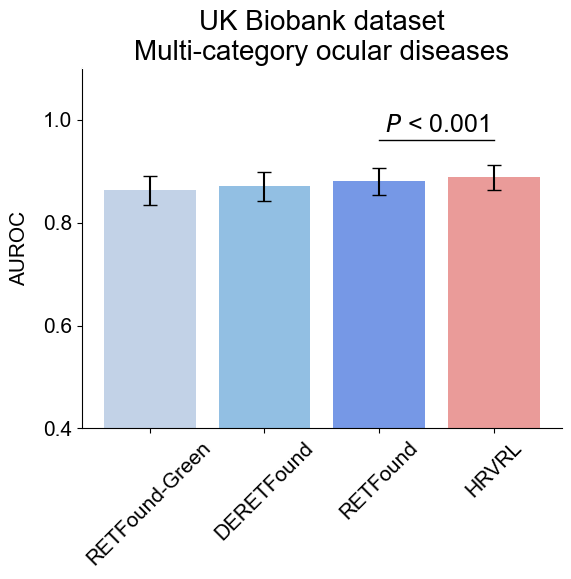

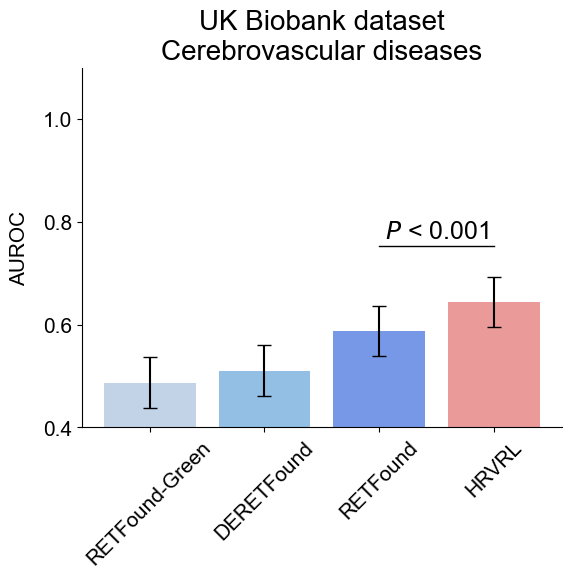

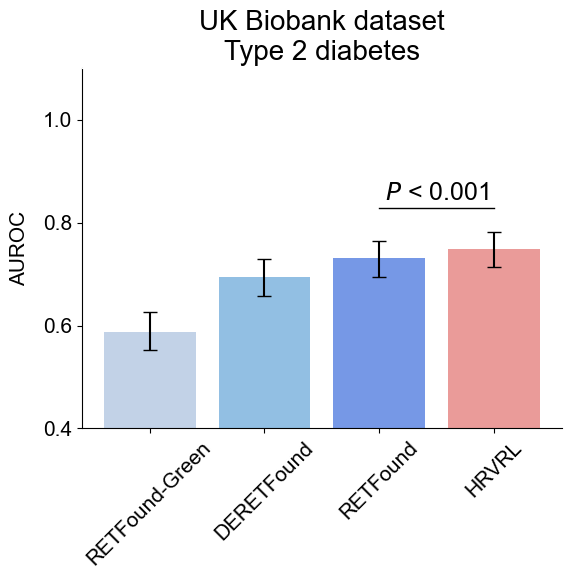

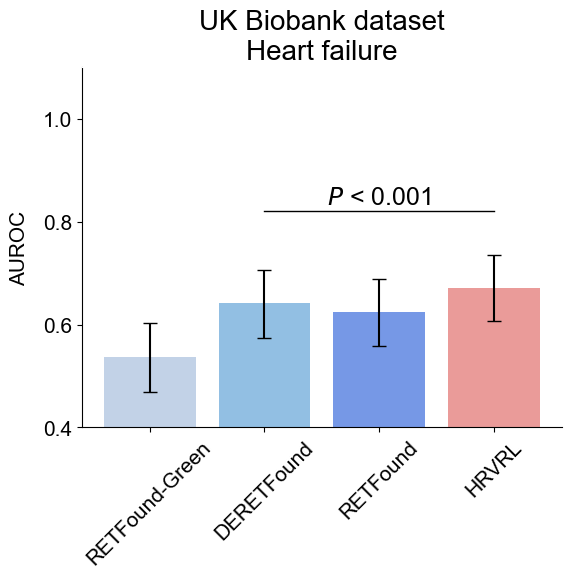

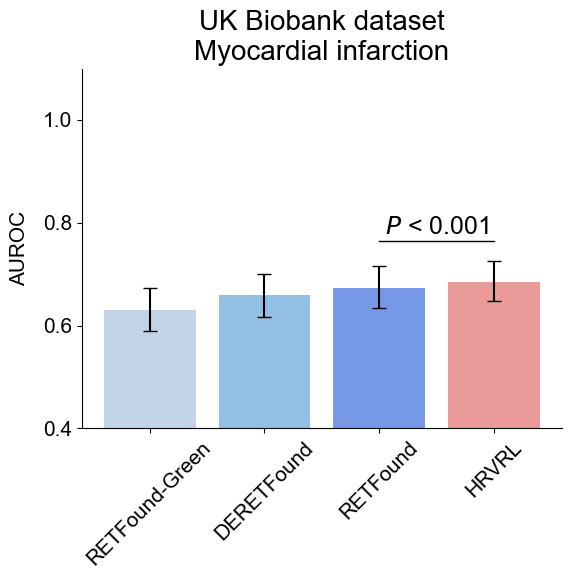

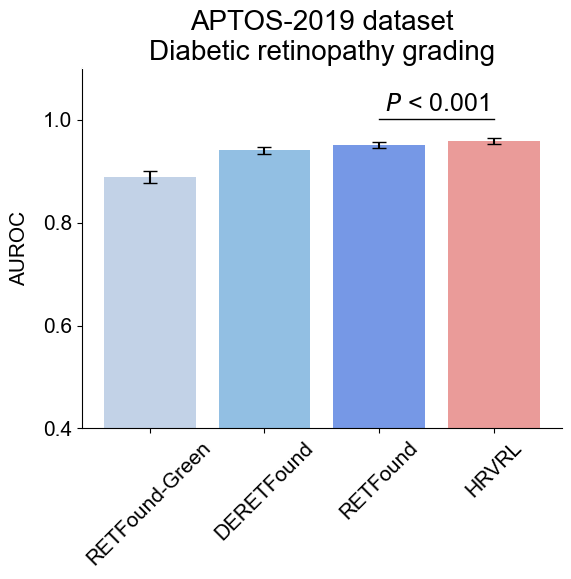

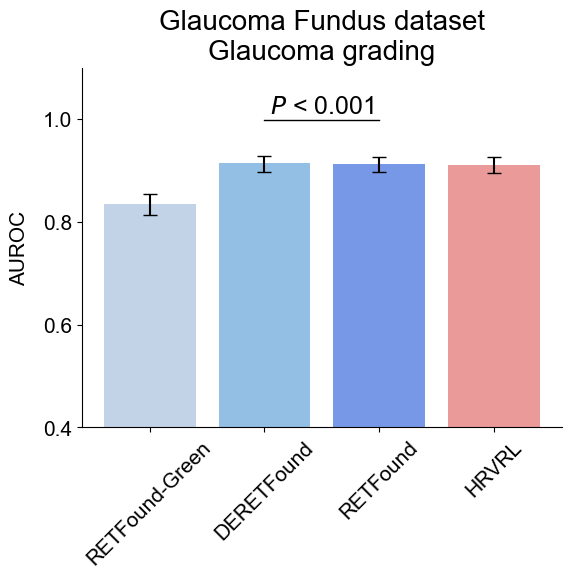

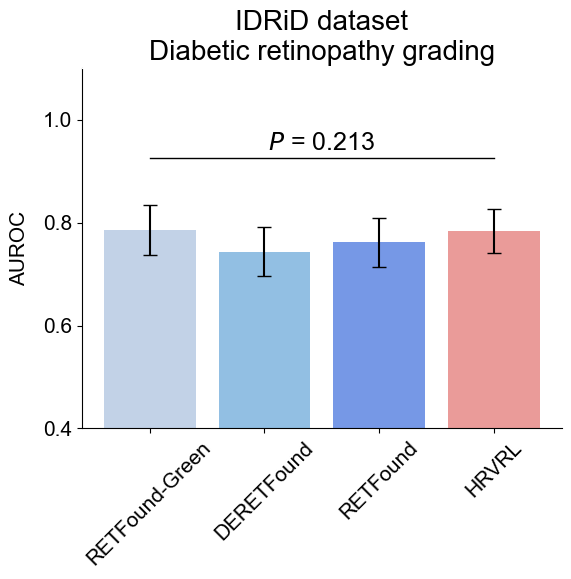

In [ ]:

np.random.seed(0)
plt.rcParams['font.family'] = 'Arial'

def get_model_stats(y_true, y_pred, nsamples=1000, fn="roc_auc_score"):
    auc_values = []
    for _ in range(nsamples):
        idx = np.random.randint(y_true.shape[0], size=y_true.shape[0])
        y_true_sample = y_true[idx]
        y_pred_sample = y_pred[idx]
        roc_auc = eval(fn)(y_true_sample, y_pred_sample)
        auc_values.append(roc_auc)

def bootstrap_ci(y_true, y_scores, n_iterations=1000):

    bootstraps_auc_roc = []
    bootstrap_auc_pr = []
    y_true = np.array(y_true).flatten()
    y_scores = np.array(y_scores).flatten()
    # print(y_scores.shape)
    for _ in range(n_iterations):
        indices = resample(range(len(y_true)), replace=True)
        #indices = np.random.randint(y_true.shape[0], size=y_true.shape[0])
        y_true_bs = y_true[indices]
        y_scores_bs = y_scores[indices]
        # 计算 Bootstrap 样本的 AUC-ROC
        score = roc_auc_score(y_true_bs, y_scores_bs)
        bootstraps_auc_roc.append(score)

        # 计算 Bootstrap 样本的 AUC-PR
        auc_pr_bs = average_precision_score(y_true_bs, y_scores_bs)
        bootstrap_auc_pr.append(auc_pr_bs)

    lower_roc = np.percentile(bootstraps_auc_roc, 2.5)
    upper_roc = np.percentile(bootstraps_auc_roc, 97.5)

    lower_pr = np.percentile(bootstrap_auc_pr, 2.5)
    upper_pr = np.percentile(bootstrap_auc_pr, 97.5)
    return lower_roc, upper_roc, lower_pr, upper_pr, bootstraps_auc_roc, bootstrap_auc_pr

def bootstrap_ci_compare(y_true, y_scores1, y_scores2,n_iterations=1000):

    bootstraps_auc_roc = []
    bootstrap_auc_pr = []
    bootstraps_auc_roc2 = []
    bootstrap_auc_pr2 = []
    y_true = np.array(y_true).flatten()
    y_scores1 = np.array(y_scores1).flatten()
    y_scores2 = np.array(y_scores2).flatten()
    for _ in range(n_iterations):
        indices = resample(range(len(y_true)), replace=True)
        #indices = np.random.randint(y_true.shape[0], size=y_true.shape[0])
        y_true_bs = y_true[indices]
        y_scores_bs1 = y_scores1[indices]
        y_scores_bs2 = y_scores2[indices]
        # 计算 Bootstrap 样本的 AUC-ROC
        score1 = roc_auc_score(y_true_bs, y_scores_bs1)
        score2 = roc_auc_score(y_true_bs, y_scores_bs2)
        bootstraps_auc_roc.append(score1)
        bootstraps_auc_roc2.append(score2)

        # 计算 Bootstrap 样本的 AUC-PR
        auc_pr_bs1 = average_precision_score(y_true_bs, y_scores_bs1)
        auc_pr_bs2 = average_precision_score(y_true_bs, y_scores_bs2)
        bootstrap_auc_pr.append(auc_pr_bs1)
        bootstrap_auc_pr2.append(auc_pr_bs2)

    s, p = ttest_ind(bootstraps_auc_roc, bootstraps_auc_roc2, equal_var=False)
    s2, p2 = ttest_ind(bootstrap_auc_pr, bootstrap_auc_pr2, equal_var=False)
    return (s, p), (s2, p2)




    # for i in os.listdir(r'D:\su-lab\NMI\T_test_roc_pr\funduSee'):
    #     df = pd.read_csv(os.path.join(r'D:\su-lab\NMI\T_test_roc_pr\funduSee',i))
    #     df.replace(r'\s+', ',', regex=True, inplace=True)
    #     pre = df['prediction_list'].tolist()
    #     la = df['true_one_hot_list'].tolist()
    #     pre = [ast.literal_eval(item) for item in pre]
    #     la = [ast.literal_eval(item) for item in la]
    #     #
    #     auc_roc = roc_auc_score(la,pre, multi_class='ovr', average='macro')
    #     print(i)
    #     print(auc_roc)
    #     print(bootstrap_ci(la,pre))

# 加载数据时启用 allow_pickle
loaded_data = np.load("reproduction/source/task_1_2_fig_plot.npz", allow_pickle=True)
# 访问数据
# print(loaded_data)
for file in loaded_data:
    # print(file)
    df = pd.DataFrame(loaded_data[file])
    # df = pd.read_csv(os.path.join(r'D:\work\T_test\t_test\brset\hrvrl\BRSET_cold_test_prediction_list.csv'))
    df.replace(r'\s+', ',', regex=True, inplace=True)
    pre = []
    values = []
    lower_errors = []
    upper_errors = []
    for i in range(8):
        pre.append(df[i].tolist())
    la = df[8].tolist()
    for i in range(8):
        pre[i] = [ast.literal_eval(item) for item in pre[i]]
    la = [ast.literal_eval(item) for item in la]
        #
        # df2 = pd.read_csv(os.path.join(r'D:\su-lab\NMI\T_test_roc_pr\det\DR_IDRID_test_prediction_list.csv'))
        # df2.replace(r'\s+', ',', regex=True, inplace=True)
        # pre2 = df2['prediction_list'].tolist()
        # la2 = df2['true_one_hot_list'].tolist()
        # pre2 = [ast.literal_eval(item) for item in pre2]
        # la2 = [ast.literal_eval(item) for item in la2]
    for i in range(8):
        up1, low1, up2, low2, roc, pr = bootstrap_ci(la, pre[i])
        df = pd.DataFrame({
            'roc': roc,
            'pr': pr
        })
    # df.to_csv(r'D:\work\T_test\auc_1\brset\hr_cold.csv', index=False)
        mean1 = np.mean(roc)
        mean2 = np.mean(pr)
        values.append(mean1)
        upper_errors.append(low1)
        lower_errors.append(up1)



    # print(f"{mean1:.3f}({up1:.3f}, {low1:.3f})\n{mean2:.3f}({up2:.3f}, {low2:.3f})")

    # print(f"{file} 数据：")
    # print(loaded_data[file])
    # 循环读取每个csv文件并分别处理
    # file_path = os.path.join(folder_path, file)
    # file_path = r'D:\work\T_test\BAR\3ID.csv'
    # file = '3ID.csv'
    ylim1 = 0.4
    ylim2 = 0.4

    # 读取csv文件
    # csv_name = file_path.split('\\')[-1]
    # file_name = csv_name.split('.')[0]

    #df.dropna(inplace=True)
    # 提取数据
    '''
    categories = df[0]
    values = df[5]
    p_value = df[6]
    #values_pr = df['']
    auc_roc = []
    Acc = df[1]
    Sen = df[2]
    Spe = df[3]
    pre = df[4]
    F1 = df[9]
    Acc = [0 if np.isnan(i) else i for i in Acc]
    Sen = [0 if np.isnan(i) else i for i in Sen]
    Spe = [0 if np.isnan(i) else i for i in Spe]
    pre = [0 if np.isnan(i) else i for i in pre]
    F1 = [0 if np.isnan(i) else i for i in F1]
    
    # 定义一个函数来提取数值
    def extract_first_value(text):
        # 提取第一个数值并转换为浮点数
        return float(re.search(r"\d+\.\d+", text).group())
    # 对Series的每个元素提取第一个数值
    first_values = values.apply(extract_first_value)

    # 定义一个函数来提取数值
    def extract_numbers(text):
        # 提取字符串中的所有浮点数
        return [float(num) for num in re.findall(r"\d+\.\d+", text)]

    # 对Series的每个元素提取所有数值
    extracted_data = values.apply(extract_numbers)
    
    # 找到第一列的两个最大值
    top_two_values = first_values.nlargest(2)
    max_idx= [0, 1]
    max_idx[0], max_idx[1] = first_values.nlargest(2).index

    # 将最大值分别保存在两个变量中
    value_max1, value_max2 = top_two_values.iloc[0], top_two_values.iloc[1]
    '''
    categories = ['RETFound\nGreen_feature', 'RETFound\nGreen_finetune', 'DERETFound_feature', 'DERETFound_finetune', 'RETFound_feature', 'RETFound_finetune', 'HRVRL_feature', 'HRVRL_finetune']
    # 定义参数
    num_groups = 4  # 数据组数
    num_colors_per_group = 400  # 每组渐变色的数量

    #t_stat, p_value = stats.ttest_ind([value_max1], [value_max2])

    # df1 = pd.DataFrame(extracted_data.tolist(), columns=['First', 'Second', 'Third'])
    lower_error = []
    upper_error = []
    # 计算第一列与第二列、第三列的差值
    for i in range(8):
        lower_error.append(values[i] - lower_errors[i])
        upper_error.append(upper_errors[i] - values[i])
    # 计算误差范围（误差的上限和下限）
    # lower_errors = auc_roc[:][0] - auc_roc[:][1]
    # upper_errors = auc_roc[:][2] - auc_roc[:][0]

    # 确保误差条没有负值
    lower_errors = np.clip(lower_errors, a_min=0, a_max=None)
    upper_errors = np.clip(upper_errors, a_min=0, a_max=None)


    # 定义渐变色
    def create_gradient_colors(start_color, end_color, num_colors):
        return [start_color] + [LinearSegmentedColormap.from_list('temp', [start_color, end_color])(i / (num_colors - 1))
                                   for i in range(1, num_colors - 1)] + [end_color]
    colors = ['#C2D2E7', '#92BFE3', '#7698E6', '#EA9B99']
    gradients = [
        create_gradient_colors('#5E6C82', '#7F8A9B', num_colors_per_group),
        create_gradient_colors('#899FB0', '#B7CBD5', num_colors_per_group),
        create_gradient_colors('#B3C6BB', '#D1DED7', num_colors_per_group),
        create_gradient_colors('#81B3A9', '#C1DDDB', num_colors_per_group)

    ]

    # 创建柱状图
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_axes([0.22, 0.25, 0.6, 0.6])
    plt.rcParams['font.family'] = 'Arial'
    # print(categories)
    # 绘制每个柱子的渐变色
    max1 = 0
    max2 = 0
    max_idx1 = 0
    max_idx2 = 0
    for i, (category, value) in enumerate(zip(categories, values)):
        if i % 2 == 0:
            gradient = gradients[int(i / 2) % num_groups]  # 选择渐变色组
            num_colors = len(gradient)
            # print(category)
            category = category.split('_')[0]
            #print(num_colors)
            # 绘制柱子
            bar_width = 0.8
            x = i
            if value >= max1:
                max2 = max1
                max1 = value
                max_idx2 = max_idx1
                max_idx1 = i
            elif value >= max2:
                max2 = value
                max_idx2 = i
            j = int(i / 2)
            # 绘制每个柱子
            if j == 0:
                plt.bar('RETFound-Green', value, bottom=0, color=colors[j], width=bar_width)
            else:
                plt.bar(category, value, bottom=0, color=colors[j], width=bar_width)
            # plt.text(int(x / 2), value + 0.003, str(value), ha='center')
            # 绘制误差条
            # print(lower_errors[i], upper_errors[i])
            plt.errorbar(int(x / 2), value, yerr=[[lower_error[i]], [upper_error[i]]], capsize=5, fmt='none',
                        color='k')

    # 设置title
    file1 = file.split('.')[0]
    if file1.startswith('1'):
        title2 = 'Multi-category ocular diseases'
        if file1.endswith('BR'):
            title1 = 'BRSET dataset'
        elif file1.endswith('PA'):
            title1 = 'PAPILA dataset'
        elif file1.endswith('Re'):
            title1 = 'Retina dataset'
        else:
            title1 = 'UK Biobank dataset'
    elif file1.startswith('2'):
        title1 = 'UK Biobank dataset'
        if file1.endswith('HF'):
            title2 = 'Heart failure'
        elif file1.endswith('CE'):
            title2 = 'Cerebrovascular diseases'
        elif file1.endswith('DE'):
            title2 = 'Type 2 diabetes'
        else:
            title2 = 'Myocardial infarction'
    else:
        title2 = 'Diabetic retinopathy grading'
        if file1.endswith('AP'):
            title1 = 'APTOS-2019 dataset'
        elif file1.endswith('ID'):
            title1 = 'IDRiD dataset'
        elif file1.endswith('GLF'):
            title1 = 'Glaucoma Fundus dataset'
            title2 = 'Glaucoma grading'
        else:
            title1 = 'MESSIDOR-2 dataset'

    title = title1 + '\n' + title2
    # 设置 y 轴下限
    plt.ylim(ylim1, 1.1)
    plt.yticks(np.arange(ylim1, 1.2, 0.2))

    # 添加T检验的p值到图中
    # 添加横放的方括号
    x1, x2 = max_idx1, max_idx2
    x1 = int(x1 / 2)
    x2 = int(x2 / 2)
    y = max(upper_errors) + 0.01
    # plt.plot([x1, x1, x2, x2], [y, y + 0.01, y + 0.01, y], lw=2, color='k')

    # 添加方括号的上部
    plt.plot([x1, x2], [y + 0.01, y + 0.01], lw=1, color='k')

    # 添加p值到图中
    # p = min(p_value)
    if file == '3ID':
        plt.text((x1 + x2) * 0.5, y + 0.015, r'$\it{P}$ = 0.213', ha='center', va='bottom', color='k', fontsize='18')
    else:
        plt.text((x1 + x2) * 0.5, y + 0.015, r'$\it{P}$ < 0.001', ha='center', va='bottom', color='k', fontsize='18')
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    # 添加标签和标题
    plt.xticks(fontsize=15, rotation=45)
    plt.yticks(fontsize=15)
    # plt.xlabel('Model')
    plt.ylabel('AUROC', fontsize=15, labelpad=10)
    plt.title(title, fontsize=20)
    outname = file1 + '_feature.svg'
    folder_path2 = r'../result'
    # print(folder_path2)
    out_path = os.path.join(folder_path2, outname)
    # print(out_path)
    # plt.savefig(out_path, format='svg')
    # 显示图表
    plt.show()
